**This notebook is designed for my understanding of the Pytorch. So the aim is break/improve things.** 

CIFAR10 with VGG like architecture, trained 100 epochs. 72.6% accuracy on test set. Obviously, there is way more than that. Shrinks the input image to 1x1 dimension at the end of the Conv Layer(right before the Linear layer).

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.202, 0.199, 0.201))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.202, 0.199, 0.201))
])

train_data = datasets.CIFAR10('data', download=True, train=True, transform=train_transform)
test_data = datasets.CIFAR10('data', download=True, train=False, transform=test_transform)

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[0:split], indices[split:]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
valid_loader = torch.utils.data.DataLoader(train_data, sampler=valid_sampler, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
LABEL_DICT = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog",
              6: "frog", 7: "horse", 8: "ship", 9: "track"}

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(8, 4))
for i in range(30):
  ax = fig.add_subplot(3, 30/3, i+1, xticks=[], yticks=[])
  img = images[i].squeeze()
  img = np.transpose(img, [1, 2, 0]) * np.array([0.202, 0.199, 0.201]) + np.array([0.491, 0.482, 0.446])
  img = np.clip(img, 0, 1)
  ax.imshow(img)
  ax.set_title(LABEL_DICT[labels[i].item()])

In [0]:
# ((n - f + 2p) / s ) + 1

In [0]:
# https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    
    filters = [3, 32, 32, 64, 64, 128, 128]
    kwargs = {"kernel_size": 3, "stride": 1, "padding": 1}
    
    self.features = nn.Sequential(OrderedDict([
        ('conv1', nn.Conv2d(filters[0], filters[1], **kwargs)), 
        ('bn1', nn.BatchNorm2d(filters[1])),
        ('relu1', nn.ReLU(inplace=True)),
        ('mpool1', nn.MaxPool2d(2)),

        ('conv2', nn.Conv2d(filters[1], filters[2], **kwargs)), 
        ('bn2', nn.BatchNorm2d(filters[2])),
        ('relu2', nn.ReLU(inplace=True)),
        ('mpool2', nn.MaxPool2d(2)),

        ('conv3', nn.Conv2d(filters[2], filters[3], **kwargs)), 
        ('bn3', nn.BatchNorm2d(filters[3])),
        ('relu3', nn.ReLU(inplace=True)),
        ('mpool3', nn.MaxPool2d(2)),

        ('conv4', nn.Conv2d(filters[3], filters[4], **kwargs)), 
        ('bn4', nn.BatchNorm2d(filters[4])),
        ('relu4', nn.ReLU(inplace=True)),
        ('mpool4', nn.MaxPool2d(2)),

        ('conv5', nn.Conv2d(filters[4], filters[5], **kwargs)), 
        ('bn5', nn.BatchNorm2d(filters[5])),
        ('relu5', nn.ReLU(inplace=True)),
        ('mpool5', nn.MaxPool2d(2))
    ]))
    self.classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(filters[5], filters[6])), # Actually there is filters[5] * 1, according to calculation above.
        ('relu1', nn.ReLU(inplace=True)),
        ('drop1', nn.Dropout(0.5)),
        ('out', nn.Linear(filters[6], 10))
        
    ]))
    
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      out = self.classifier(x)
      return out

In [11]:
model = VGG()
print(model)

VGG(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (mpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (mpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(64, eps=1e

In [12]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
total_params = sum(p.numel() for p in model.parameters())
total_params

157866

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-2)

In [0]:
train_on_gpu = True if torch.cuda.is_available() else False

if train_on_gpu:
  model = model.cuda()

In [15]:
n_epochs = 100
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(n_epochs):
  train_loss = 0.0
  valid_loss = 0.0
  train_acc = 0
  valid_acc = 0
  
  model.train()
  for data, target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()      
    
    optimizer.zero_grad()
    preds = model(data)
    loss = criterion(preds, target)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item() * data.size(0)
    
    _, preds = torch.max(preds.data, dim=1)
    train_acc += (preds == target).sum().item()
    
  model.eval()
  for data, target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
      
    preds = model(data)
    loss = criterion(preds, target)
    valid_loss += loss.item() * data.size(0)
    _, preds = torch.max(preds, dim=1)
    valid_acc += (preds == target).sum().item()
  
  train_loss /= len(train_idx)
  valid_loss /= len(valid_idx)
  train_acc /= len(train_idx)
  valid_acc /= len(valid_idx)
  
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)  
  train_accs.append(train_acc)
  valid_accs.append(valid_acc)
  
  print("Epoch: {}/{}\tLoss: {:.4f}\tAccuracy: {:.4f}\tVal_loss: {:.4f}\tVal_acc: {:.4f}".format(epoch+1, n_epochs,
                                                                                                 train_loss, train_acc,
                                                                                                 valid_loss, valid_acc))

Epoch: 1/100	Loss: 2.0399	Accuracy: 0.2067	Val_loss: 2.1737	Val_acc: 0.2179
Epoch: 2/100	Loss: 1.8752	Accuracy: 0.2524	Val_loss: 1.7972	Val_acc: 0.2812
Epoch: 3/100	Loss: 1.7844	Accuracy: 0.2959	Val_loss: 1.8126	Val_acc: 0.3210
Epoch: 4/100	Loss: 1.7191	Accuracy: 0.3369	Val_loss: 1.6189	Val_acc: 0.3524
Epoch: 5/100	Loss: 1.6659	Accuracy: 0.3599	Val_loss: 1.5310	Val_acc: 0.3999
Epoch: 6/100	Loss: 1.6028	Accuracy: 0.3866	Val_loss: 1.6003	Val_acc: 0.4049
Epoch: 7/100	Loss: 1.5686	Accuracy: 0.4058	Val_loss: 1.6189	Val_acc: 0.3937
Epoch: 8/100	Loss: 1.5308	Accuracy: 0.4289	Val_loss: 1.3985	Val_acc: 0.4522
Epoch: 9/100	Loss: 1.4609	Accuracy: 0.4526	Val_loss: 1.3478	Val_acc: 0.5092
Epoch: 10/100	Loss: 1.4540	Accuracy: 0.4608	Val_loss: 1.3971	Val_acc: 0.4793
Epoch: 11/100	Loss: 1.4304	Accuracy: 0.4742	Val_loss: 1.2985	Val_acc: 0.5213
Epoch: 12/100	Loss: 1.4013	Accuracy: 0.4865	Val_loss: 1.2810	Val_acc: 0.5332
Epoch: 13/100	Loss: 1.3876	Accuracy: 0.4882	Val_loss: 1.2566	Val_acc: 0.5477
Epoch: 1

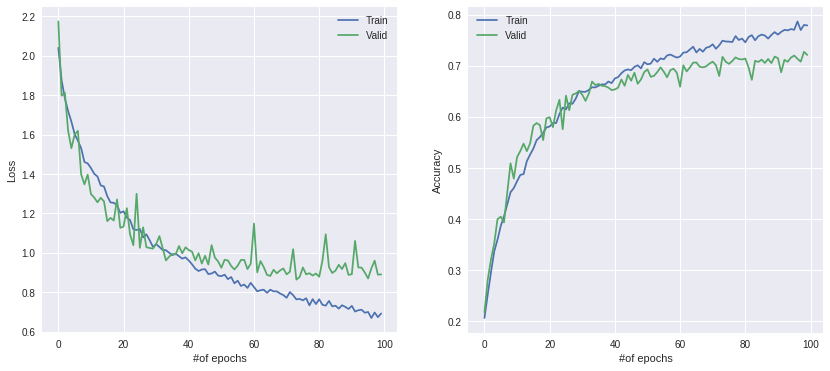

In [16]:
fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(np.arange(n_epochs), train_losses, label="Train")
ax.plot(np.arange(n_epochs), valid_losses, label="Valid")
ax.set_xlabel("#of epochs")
ax.set_ylabel("Loss")
ax.legend();

ax = fig.add_subplot(1, 2, 2)
ax.plot(np.arange(n_epochs), train_accs, label="Train")
ax.plot(np.arange(n_epochs), valid_accs, label="Valid")
ax.set_xlabel("#of epochs")
ax.set_ylabel("Accuracy")
ax.legend();

In [17]:
test_loss = 0.0
test_acc = 0

with torch.no_grad():
  model.eval()
  
  for data, target in test_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    
    preds = model(data)
    loss = criterion(preds, target)
    test_loss += loss.item() * data.size(0)
    
    _, preds = torch.max(preds, 1)
    test_acc += (preds == target).sum().item()

  test_loss /= len(test_loader.dataset)
  test_acc /= len(test_loader.dataset)
  print("Test Loss: {}\tTest Acc: {}".format(test_loss, test_acc))

Test Loss: 0.9082648855209351	Test Acc: 0.7266
